### 이 파일이 이미지로 점수 예측하는 코드입니다. 

# 0. 실행할 부분

In [1]:
# torchvision 관련 라이브러리 import

from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

/nfs/home/dailyavenger/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install jsonlines
!pip install pdf2image

In [3]:
#@title

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models



In [4]:
#@title
from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import glob
from PIL import Image
import jsonlines
import os
from tqdm import tqdm

#1. 데이터셋 로드


In [5]:
#@title
import cv2,io

class PaperDataSet(Dataset):
    def __init__(self, overall_image_path, transform=None):
        print("initialize data sets")
        self.transform = transform
        rating_dict = {}
        self.image_list = list()
        self.score_list = list()
        years = ["2021"]
        for year in years:
            cnt = 0
            year_image_path = overall_image_path
            # year_image_path = overall_image_path+"iclr"+year+"/"
            # *********** 경로 수정 ***********
            with jsonlines.open(f"iclr{year}_metadata.jsonl") as read_file:
                for line in read_file.iter():
                    rating_dict[line['forum']] = line['rating']
            input_paths = os.listdir(year_image_path)
            ignore_4 = True
            ignore_5 = True
            ignore_6 = True
            for one_file_image_path in tqdm(input_paths, desc="make data set"):
               
                image_path = year_image_path + one_file_image_path + "/"
                rating = rating_dict[one_file_image_path]
                iter=1
                rating_int = int(rating)
                if rating_int==2:
                  iter = 2
                elif rating_int==3:
                  iter = 2
                elif rating_int==7:
                  iter = 2
                elif rating_int==8:
                  iter = 2

                elif rating_int==4:
                  if ignore_4:
                    iter = 0
                    ignore_4 = False
                  else:
                    ignore_4 = True

                elif rating_int==5:
                  if ignore_5:
                    iter = 0
                    ignore_5 = False
                  else:
                    ignore_5 = True

                elif rating_int==6:
                  if ignore_6:
                    iter = 0
                    ignore_6 = False
                  else:
                    ignore_6 = True
                    

                for _ in range(iter): 
                    before_add_size = len(self.image_list)
                    self.image_list.extend(glob.glob(image_path + "*.bin")) # glob: 폴더 내의 파일 찾아줌   
                    self.score_list.extend([rating] * (len(self.image_list)-before_add_size))
                
                
            print(f"{year}: {cnt}")

    def __len__(self):
        return len(self.image_list)


    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        label = self.score_list[idx]
        binary_file = image_path   # binary_file = dataset/image/iclr2021/_0kaDkv3dVf/3.bin 
        with open(binary_file, 'rb') as f:
            data = f.read()
        encoded_img = np.fromstring(data, dtype=np.uint8)
        img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 

        for i in range(0,224):
            for j in range(0,224):
                for b in range(0,3):
                    if(i<=11):
                        img[i][j][b]=255

        if self.transform is not None:
            img = self.transform(img)
        
        return img, label
        
    def get__score_list(self):
        return self.score_list

In [6]:
image_path =  "../wngusrud27/dataset/image/iclr2021/" 
image_path2 =  "temp/" 
dataset_file_name = 'iclr2021_dataset.pt'

In [7]:
#zip_path = image_path + "iclr2021_binary.zip"

#!mkdir binary

#!cp {zip_path} ./iclr2021.zip

#!unzip -q ./iclr2021.zip -d ./binary/ 

#!rm ./iclr2021.zip

In [8]:
def make_save_data_set(image_path2, dataset_file_name):
  print("start to make data set")
  transform = transforms.Compose([
      transforms.ToTensor(),
  ])

  dataset = PaperDataSet(image_path, transform=transform)
  print(f"data set length: {dataset.__len__()}")

  torch.save(dataset, image_path2 + dataset_file_name)
  print("save data sets")

In [9]:
#image_path =  "./binary/" 
make_save_data_set(image_path2, dataset_file_name)
# data_set_usage_ex(dataset_file_name)

start to make data set
initialize data sets


make data set: 100%|██████████| 2594/2594 [00:00<00:00, 5461.49it/s]


2021: 0
data set length: 16407
save data sets


In [10]:
from torch.utils.data.dataset import random_split
import torchvision.datasets as dset

dataset = torch.load(image_path2+dataset_file_name)

train_size = int(0.8 * len(dataset))
print("train size:", train_size)

test_size = len(dataset) - train_size
print("test size:", test_size)
# validation 
train_dataset, test_dataset = random_split(dataset, [train_size,test_size])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

train size: 13125
test size: 3282


In [11]:
score_list = dataset.get__score_list()
lst = [0]*10
for score in score_list:
  score_int = int(score)
  lst[score_int] +=1
print(lst)

[0, 0, 234, 2358, 2466, 4176, 3447, 3474, 252, 0]


# 2 모델 생성,하이퍼 파라미터 설정

In [12]:
from torchvision import models
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정

resnet50 = models.resnet50(pretrained=False).to(device) # true 옵션으로 사전 학습된 모델을 로드

# transfer learning 사용 시 추가 
# if using_transfer_learning:|
#   for param in resnet50.parameters():
#     param.requires_grad = False

def create_model(input_channel, using_transfer_learning=True):
  
  assert(input_channel % 3 == 0, "The number of channels needs to be a multiple of 3")
  resnet50 = models.resnet50(pretrained=using_transfer_learning).to(device)
  if input_channel != 3:
    old_layer = resnet50.conv1
    
    # Creating a new Conv2d layer
    new_layer = nn.Conv2d(in_channels=input_channel, # 3 -> input_channel
                      out_channels=old_layer.out_channels, # 64
                      kernel_size=old_layer.kernel_size, # (7, 7)
                      stride=old_layer.stride, # (2, 2)
                      padding=old_layer.padding, # (3, 3)
                      bias=old_layer.bias) # False
    if using_transfer_learning:
      for channel in range(3, input_channel, 3):
        new_layer.weight[:, channel:channel+3, :, :] = old_layer.weight[:, 0:3, : :].clone()
    with torch.no_grad():
      # Copying the weights from the old to the new layer
      new_layer.weight[:, 0:3, :, :] = old_layer.weight.clone()
      
    new_layer.weight = nn.Parameter(new_layer.weight, requires_grad=(not using_transfer_learning))
  
    resnet50.conv1 = new_layer
  if using_transfer_learning:
    for param in resnet50.parameters():
      param.requires_grad = False
  # model = nn.Sequential(
  #     resnet50,
  #     nn.Flatten(),
  #     nn.Linear(1000, 256),
  #     nn.ReLU(),
  #     nn.Linear(256, 32),
  #     nn.ReLU(),
  #     nn.Linear(32, 1)
  # ).to(device)
  old_fc_in_features = resnet50.fc.in_features # = 2048
  resnet50.fc = nn.Linear(old_fc_in_features, 1)
  return resnet50.to(device)
  # return model


<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_3292837/4267760019.py:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(input_channel % 3 == 0, "The number of channels needs to be a multiple of 3")


In [13]:
import torch
import torch.nn as nn
from torch import optim
lr = 0.0001
num_epochs = 50
model=create_model(3,False)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)

In [14]:
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_dataloader,
    'test_dataloader': test_dataloader,
    'device':device
}

# 3. 학습

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [16]:
import time
import datetime
from numpy import vstack

def train(model, params):
  total_start = time.time()
  loss_function=params["loss_function"]
  train_dataloader=params["train_dataloader"]
  test_dataloader=params["test_dataloader"]
  device=params["device"]

  print("start train")
  print("train size:", train_size)
  print("test size:", test_size)
  min_loss=999999
  average_total=0
  average_accuracy=0
  for epoch in range(0, num_epochs):

    model.train()
    epoch_start = time.time()
    trained_number = 0
    for i, data in enumerate(train_dataloader, 0):
        
        # train dataloader 로 불러온 데이터에서 이미지와 라벨을 분리
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)
        
        # 이전 batch에서 계산된 가중치를 초기화
      optimizer.zero_grad() 
        # forward + back propagation 연산
      outputs = model(inputs).squeeze()
      train_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32))
      train_loss.backward()
      optimizer.step()
      trained_number += labels.size(0)
        
      if i%100==0:
        print(f"epoch {epoch+1} {trained_number/train_size*100}% train finish")
    print(f"epoch {epoch+1} train finish") 

  

    model.eval()
      # test accuracy 계산
    total = 0
    correct = 0
    loss = 0
    correct2 = 0 
    
    score_list = list()   ##새로 추가
    predict_list = list()
    

    for i, data in enumerate(test_dataloader, 0):
        
      inputs, labels = data        
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)
        

        # 결과값 연산
      outputs = model(inputs).squeeze()
      score_list.extend(labels.detach().cpu().numpy()) ##새로 추가
      predict_list.extend(outputs.detach().cpu().numpy())## 새로추가

      i_batch_size = labels.size(0)
      total += i_batch_size
      correct += (abs(outputs - labels)<0.5).sum().item() # 변경될 수 있음 
      correct2 += (abs(outputs - labels)).sum().item()
      test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
      loss += i_batch_size * test_loss
      if i%50==0:
        print(f"epoch {epoch+1} {total/test_size*100}% test finish")
        # break
    
    import matplotlib.pyplot as plt ##새로 추가
    plt.scatter(score_list,predict_list) ##새로 추가 .numpy()
    plt.xlabel('evaluation score')
    plt.ylabel('predicted score')
    plt.show()
    plt.savefig(f"my_plot3_{epoch}.png")
    plt.close()
      # 학습 결과 출력
    print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f, difference: %.6f' %(epoch+1, num_epochs, train_loss.item(), loss/total, 100*correct/total, correct2/total)) #, correct2/total
    average_total+= loss/total
    average_accuracy+=100*correct/total
    if(min_loss > loss/total):
      min_loss=loss/total
      torch.save(model.state_dict(), f"temp/model{epoch}" )

  average_total/=num_epochs 
  average_accuracy/=num_epochs
  print("min loss:", min_loss)
  print("average_loss:", average_total)
  print("average_accuracy:", average_accuracy)    
    #epoch_elapsed_time = time.time() - epoch_start
    #epoch_elapsed_time_list = str(datetime.timedelta(seconds=epoch_elapsed_time)).split(".")
    #total_elapsed_time = time.time() - total_start
    #total_elapsed_time_list = str(datetime.timedelta(seconds=total_elapsed_time)).split(".")
    #print(f"Epoch {epoch+1} Elapsed time is {epoch_elapsed_time_list[0]}")  
    #print(f"Total Elapsed time is {total_elapsed_time_list[0]}")  


start train
train size: 13125
test size: 3282


/tmp/ipykernel_3292837/2047555428.py:79: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img = np.fromstring(data, dtype=np.uint8)


epoch 1 0.12190476190476189% train finish
epoch 1 12.312380952380952% train finish
epoch 1 24.502857142857142% train finish
epoch 1 36.693333333333335% train finish
epoch 1 48.883809523809525% train finish
epoch 1 61.074285714285715% train finish
epoch 1 73.26476190476191% train finish
epoch 1 85.4552380952381% train finish
epoch 1 97.64571428571429% train finish
epoch 1 train finish
epoch 1 0.4875076173065204% test finish
epoch 1 24.862888482632542% test finish
epoch 1 49.238269347958564% test finish
epoch 1 73.61365021328459% test finish
epoch 1 97.9890310786106% test finish


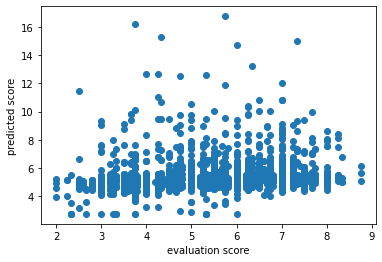

Epoch: 1/50, Train loss: 1.481907, Test loss: 2.520907, Accuracy: 23.37, difference: 1.250867
epoch 2 0.12190476190476189% train finish
epoch 2 12.312380952380952% train finish
epoch 2 24.502857142857142% train finish
epoch 2 36.693333333333335% train finish
epoch 2 48.883809523809525% train finish
epoch 2 61.074285714285715% train finish
epoch 2 73.26476190476191% train finish
epoch 2 85.4552380952381% train finish
epoch 2 97.64571428571429% train finish
epoch 2 train finish
epoch 2 0.4875076173065204% test finish
epoch 2 24.862888482632542% test finish
epoch 2 49.238269347958564% test finish
epoch 2 73.61365021328459% test finish
epoch 2 97.9890310786106% test finish


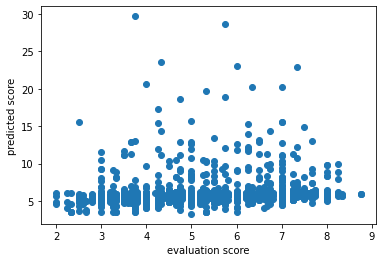

Epoch: 2/50, Train loss: 2.047116, Test loss: 3.673454, Accuracy: 24.95, difference: 1.250628
epoch 3 0.12190476190476189% train finish
epoch 3 12.312380952380952% train finish
epoch 3 24.502857142857142% train finish
epoch 3 36.693333333333335% train finish
epoch 3 48.883809523809525% train finish
epoch 3 61.074285714285715% train finish
epoch 3 73.26476190476191% train finish
epoch 3 85.4552380952381% train finish
epoch 3 97.64571428571429% train finish
epoch 3 train finish
epoch 3 0.4875076173065204% test finish
epoch 3 24.862888482632542% test finish
epoch 3 49.238269347958564% test finish
epoch 3 73.61365021328459% test finish
epoch 3 97.9890310786106% test finish


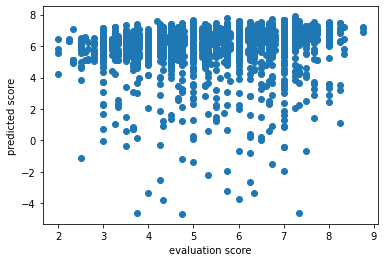

Epoch: 3/50, Train loss: 1.338000, Test loss: 3.215345, Accuracy: 26.75, difference: 1.345914
epoch 4 0.12190476190476189% train finish
epoch 4 12.312380952380952% train finish
epoch 4 24.502857142857142% train finish
epoch 4 36.693333333333335% train finish
epoch 4 48.883809523809525% train finish
epoch 4 61.074285714285715% train finish
epoch 4 73.26476190476191% train finish
epoch 4 85.4552380952381% train finish
epoch 4 97.64571428571429% train finish
epoch 4 train finish
epoch 4 0.4875076173065204% test finish
epoch 4 24.862888482632542% test finish
epoch 4 49.238269347958564% test finish
epoch 4 73.61365021328459% test finish
epoch 4 97.9890310786106% test finish


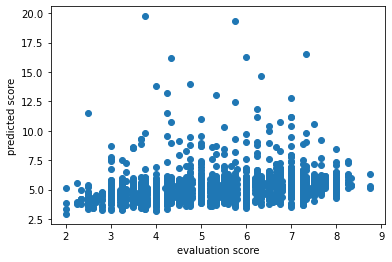

Epoch: 4/50, Train loss: 1.493970, Test loss: 2.429836, Accuracy: 24.62, difference: 1.190288
epoch 5 0.12190476190476189% train finish
epoch 5 12.312380952380952% train finish
epoch 5 24.502857142857142% train finish
epoch 5 36.693333333333335% train finish
epoch 5 48.883809523809525% train finish
epoch 5 61.074285714285715% train finish
epoch 5 73.26476190476191% train finish
epoch 5 85.4552380952381% train finish
epoch 5 97.64571428571429% train finish
epoch 5 train finish
epoch 5 0.4875076173065204% test finish
epoch 5 24.862888482632542% test finish
epoch 5 49.238269347958564% test finish
epoch 5 73.61365021328459% test finish
epoch 5 97.9890310786106% test finish


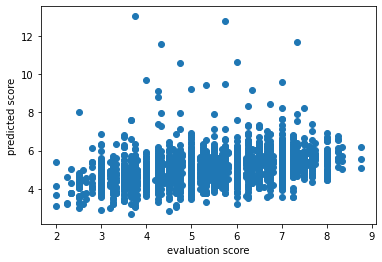

Epoch: 5/50, Train loss: 1.073154, Test loss: 1.843510, Accuracy: 25.75, difference: 1.106091
epoch 6 0.12190476190476189% train finish
epoch 6 12.312380952380952% train finish
epoch 6 24.502857142857142% train finish
epoch 6 36.693333333333335% train finish
epoch 6 48.883809523809525% train finish
epoch 6 61.074285714285715% train finish
epoch 6 73.26476190476191% train finish
epoch 6 85.4552380952381% train finish
epoch 6 97.64571428571429% train finish
epoch 6 train finish
epoch 6 0.4875076173065204% test finish
epoch 6 24.862888482632542% test finish
epoch 6 49.238269347958564% test finish
epoch 6 73.61365021328459% test finish
epoch 6 97.9890310786106% test finish


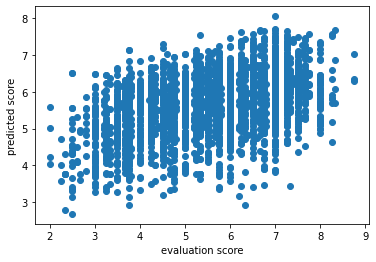

Epoch: 6/50, Train loss: 1.852092, Test loss: 1.568386, Accuracy: 27.76, difference: 1.026644
epoch 7 0.12190476190476189% train finish
epoch 7 12.312380952380952% train finish
epoch 7 24.502857142857142% train finish
epoch 7 36.693333333333335% train finish
epoch 7 48.883809523809525% train finish
epoch 7 61.074285714285715% train finish
epoch 7 73.26476190476191% train finish
epoch 7 85.4552380952381% train finish
epoch 7 97.64571428571429% train finish
epoch 7 train finish
epoch 7 0.4875076173065204% test finish
epoch 7 24.862888482632542% test finish
epoch 7 49.238269347958564% test finish
epoch 7 73.61365021328459% test finish
epoch 7 97.9890310786106% test finish


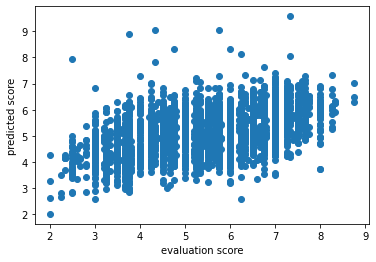

Epoch: 7/50, Train loss: 2.266914, Test loss: 1.548257, Accuracy: 27.73, difference: 1.025359
epoch 8 0.12190476190476189% train finish
epoch 8 12.312380952380952% train finish
epoch 8 24.502857142857142% train finish
epoch 8 36.693333333333335% train finish
epoch 8 48.883809523809525% train finish
epoch 8 61.074285714285715% train finish
epoch 8 73.26476190476191% train finish
epoch 8 85.4552380952381% train finish
epoch 8 97.64571428571429% train finish
epoch 8 train finish
epoch 8 0.4875076173065204% test finish
epoch 8 24.862888482632542% test finish
epoch 8 49.238269347958564% test finish
epoch 8 73.61365021328459% test finish
epoch 8 97.9890310786106% test finish


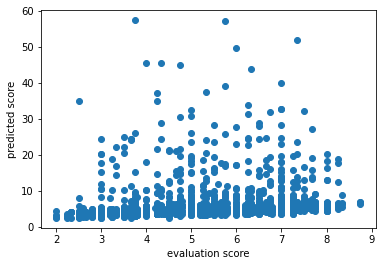

Epoch: 8/50, Train loss: 0.703850, Test loss: 17.471244, Accuracy: 25.47, difference: 1.787133
epoch 9 0.12190476190476189% train finish
epoch 9 12.312380952380952% train finish
epoch 9 24.502857142857142% train finish
epoch 9 36.693333333333335% train finish
epoch 9 48.883809523809525% train finish
epoch 9 61.074285714285715% train finish
epoch 9 73.26476190476191% train finish
epoch 9 85.4552380952381% train finish
epoch 9 97.64571428571429% train finish
epoch 9 train finish
epoch 9 0.4875076173065204% test finish
epoch 9 24.862888482632542% test finish
epoch 9 49.238269347958564% test finish
epoch 9 73.61365021328459% test finish
epoch 9 97.9890310786106% test finish


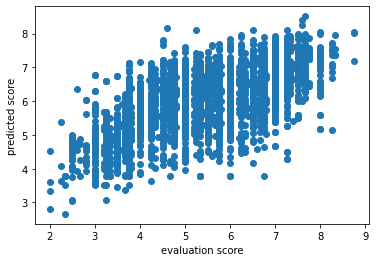

Epoch: 9/50, Train loss: 1.221959, Test loss: 1.347595, Accuracy: 33.46, difference: 0.929854
epoch 10 0.12190476190476189% train finish
epoch 10 12.312380952380952% train finish
epoch 10 24.502857142857142% train finish
epoch 10 36.693333333333335% train finish
epoch 10 48.883809523809525% train finish
epoch 10 61.074285714285715% train finish
epoch 10 73.26476190476191% train finish
epoch 10 85.4552380952381% train finish
epoch 10 97.64571428571429% train finish
epoch 10 train finish
epoch 10 0.4875076173065204% test finish
epoch 10 24.862888482632542% test finish
epoch 10 49.238269347958564% test finish
epoch 10 73.61365021328459% test finish
epoch 10 97.9890310786106% test finish


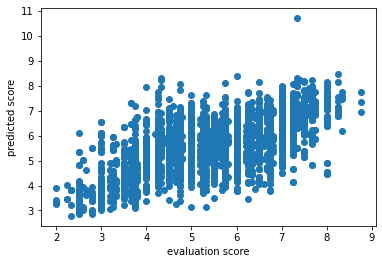

Epoch: 10/50, Train loss: 0.137699, Test loss: 1.078410, Accuracy: 37.63, difference: 0.812654
epoch 11 0.12190476190476189% train finish
epoch 11 12.312380952380952% train finish
epoch 11 24.502857142857142% train finish
epoch 11 36.693333333333335% train finish
epoch 11 48.883809523809525% train finish
epoch 11 61.074285714285715% train finish
epoch 11 73.26476190476191% train finish
epoch 11 85.4552380952381% train finish
epoch 11 97.64571428571429% train finish
epoch 11 train finish
epoch 11 0.4875076173065204% test finish
epoch 11 24.862888482632542% test finish
epoch 11 49.238269347958564% test finish
epoch 11 73.61365021328459% test finish
epoch 11 97.9890310786106% test finish


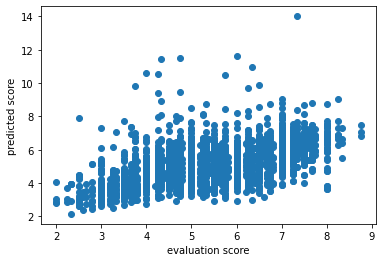

Epoch: 11/50, Train loss: 0.940540, Test loss: 1.517745, Accuracy: 32.11, difference: 0.959894
epoch 12 0.12190476190476189% train finish
epoch 12 12.312380952380952% train finish
epoch 12 24.502857142857142% train finish
epoch 12 36.693333333333335% train finish
epoch 12 48.883809523809525% train finish
epoch 12 61.074285714285715% train finish
epoch 12 73.26476190476191% train finish
epoch 12 85.4552380952381% train finish
epoch 12 97.64571428571429% train finish
epoch 12 train finish
epoch 12 0.4875076173065204% test finish
epoch 12 24.862888482632542% test finish
epoch 12 49.238269347958564% test finish
epoch 12 73.61365021328459% test finish
epoch 12 97.9890310786106% test finish


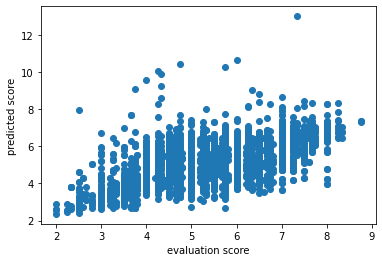

Epoch: 12/50, Train loss: 0.247886, Test loss: 1.263481, Accuracy: 35.50, difference: 0.874909
epoch 13 0.12190476190476189% train finish
epoch 13 12.312380952380952% train finish
epoch 13 24.502857142857142% train finish
epoch 13 36.693333333333335% train finish
epoch 13 48.883809523809525% train finish
epoch 13 61.074285714285715% train finish
epoch 13 73.26476190476191% train finish
epoch 13 85.4552380952381% train finish
epoch 13 97.64571428571429% train finish
epoch 13 train finish
epoch 13 0.4875076173065204% test finish
epoch 13 24.862888482632542% test finish
epoch 13 49.238269347958564% test finish
epoch 13 73.61365021328459% test finish
epoch 13 97.9890310786106% test finish


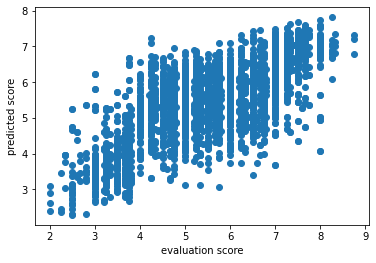

Epoch: 13/50, Train loss: 0.554008, Test loss: 0.902504, Accuracy: 40.28, difference: 0.751234
epoch 14 0.12190476190476189% train finish
epoch 14 12.312380952380952% train finish
epoch 14 24.502857142857142% train finish
epoch 14 36.693333333333335% train finish
epoch 14 48.883809523809525% train finish
epoch 14 61.074285714285715% train finish
epoch 14 73.26476190476191% train finish
epoch 14 85.4552380952381% train finish
epoch 14 97.64571428571429% train finish
epoch 14 train finish
epoch 14 0.4875076173065204% test finish
epoch 14 24.862888482632542% test finish
epoch 14 49.238269347958564% test finish
epoch 14 73.61365021328459% test finish
epoch 14 97.9890310786106% test finish


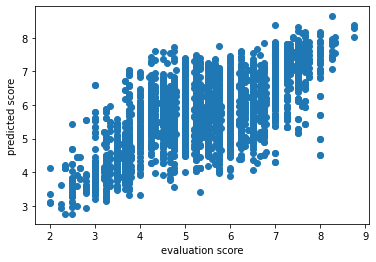

Epoch: 14/50, Train loss: 0.227565, Test loss: 0.982859, Accuracy: 42.60, difference: 0.766173
epoch 15 0.12190476190476189% train finish
epoch 15 12.312380952380952% train finish
epoch 15 24.502857142857142% train finish
epoch 15 36.693333333333335% train finish
epoch 15 48.883809523809525% train finish
epoch 15 61.074285714285715% train finish
epoch 15 73.26476190476191% train finish
epoch 15 85.4552380952381% train finish
epoch 15 97.64571428571429% train finish
epoch 15 train finish
epoch 15 0.4875076173065204% test finish
epoch 15 24.862888482632542% test finish
epoch 15 49.238269347958564% test finish
epoch 15 73.61365021328459% test finish
epoch 15 97.9890310786106% test finish


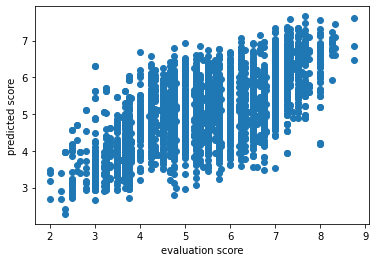

Epoch: 15/50, Train loss: 0.300735, Test loss: 1.166654, Accuracy: 33.49, difference: 0.876006
epoch 16 0.12190476190476189% train finish
epoch 16 12.312380952380952% train finish
epoch 16 24.502857142857142% train finish
epoch 16 36.693333333333335% train finish
epoch 16 48.883809523809525% train finish
epoch 16 61.074285714285715% train finish
epoch 16 73.26476190476191% train finish
epoch 16 85.4552380952381% train finish
epoch 16 97.64571428571429% train finish
epoch 16 train finish
epoch 16 0.4875076173065204% test finish
epoch 16 24.862888482632542% test finish
epoch 16 49.238269347958564% test finish
epoch 16 73.61365021328459% test finish
epoch 16 97.9890310786106% test finish


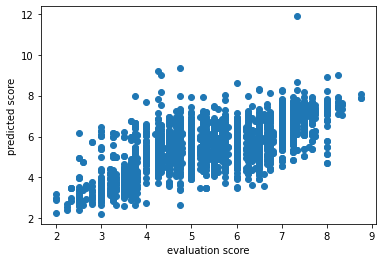

Epoch: 16/50, Train loss: 0.089245, Test loss: 0.914456, Accuracy: 48.20, difference: 0.714094
epoch 17 0.12190476190476189% train finish
epoch 17 12.312380952380952% train finish
epoch 17 24.502857142857142% train finish
epoch 17 36.693333333333335% train finish
epoch 17 48.883809523809525% train finish
epoch 17 61.074285714285715% train finish
epoch 17 73.26476190476191% train finish
epoch 17 85.4552380952381% train finish
epoch 17 97.64571428571429% train finish
epoch 17 train finish
epoch 17 0.4875076173065204% test finish
epoch 17 24.862888482632542% test finish
epoch 17 49.238269347958564% test finish
epoch 17 73.61365021328459% test finish
epoch 17 97.9890310786106% test finish


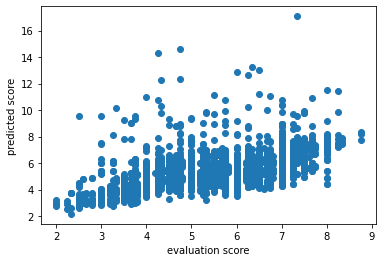

Epoch: 17/50, Train loss: 0.061490, Test loss: 1.381783, Accuracy: 43.85, difference: 0.805289
epoch 18 0.12190476190476189% train finish
epoch 18 12.312380952380952% train finish
epoch 18 24.502857142857142% train finish
epoch 18 36.693333333333335% train finish
epoch 18 48.883809523809525% train finish
epoch 18 61.074285714285715% train finish
epoch 18 73.26476190476191% train finish
epoch 18 85.4552380952381% train finish
epoch 18 97.64571428571429% train finish
epoch 18 train finish
epoch 18 0.4875076173065204% test finish
epoch 18 24.862888482632542% test finish
epoch 18 49.238269347958564% test finish
epoch 18 73.61365021328459% test finish
epoch 18 97.9890310786106% test finish


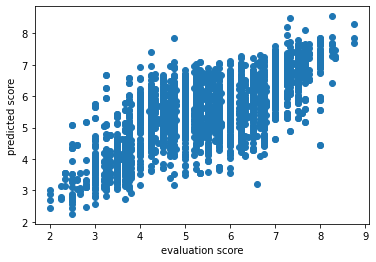

Epoch: 18/50, Train loss: 0.273043, Test loss: 0.827636, Accuracy: 43.75, difference: 0.712668
epoch 19 0.12190476190476189% train finish
epoch 19 12.312380952380952% train finish
epoch 19 24.502857142857142% train finish
epoch 19 36.693333333333335% train finish
epoch 19 48.883809523809525% train finish
epoch 19 61.074285714285715% train finish
epoch 19 73.26476190476191% train finish
epoch 19 85.4552380952381% train finish
epoch 19 97.64571428571429% train finish
epoch 19 train finish
epoch 19 0.4875076173065204% test finish
epoch 19 24.862888482632542% test finish
epoch 19 49.238269347958564% test finish
epoch 19 73.61365021328459% test finish
epoch 19 97.9890310786106% test finish


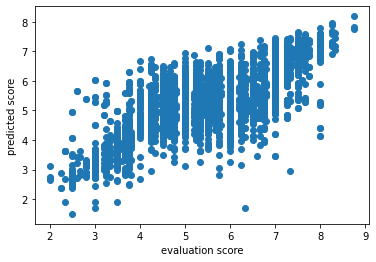

Epoch: 19/50, Train loss: 0.122216, Test loss: 0.856084, Accuracy: 43.57, difference: 0.718176
epoch 20 0.12190476190476189% train finish
epoch 20 12.312380952380952% train finish
epoch 20 24.502857142857142% train finish
epoch 20 36.693333333333335% train finish
epoch 20 48.883809523809525% train finish
epoch 20 61.074285714285715% train finish
epoch 20 73.26476190476191% train finish
epoch 20 85.4552380952381% train finish
epoch 20 97.64571428571429% train finish
epoch 20 train finish
epoch 20 0.4875076173065204% test finish
epoch 20 24.862888482632542% test finish
epoch 20 49.238269347958564% test finish
epoch 20 73.61365021328459% test finish
epoch 20 97.9890310786106% test finish


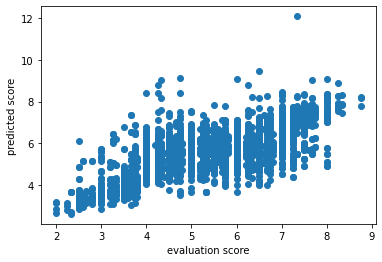

Epoch: 20/50, Train loss: 0.075980, Test loss: 0.890662, Accuracy: 47.75, difference: 0.706136
epoch 21 0.12190476190476189% train finish
epoch 21 12.312380952380952% train finish
epoch 21 24.502857142857142% train finish
epoch 21 36.693333333333335% train finish
epoch 21 48.883809523809525% train finish
epoch 21 61.074285714285715% train finish
epoch 21 73.26476190476191% train finish
epoch 21 85.4552380952381% train finish
epoch 21 97.64571428571429% train finish
epoch 21 train finish
epoch 21 0.4875076173065204% test finish
epoch 21 24.862888482632542% test finish
epoch 21 49.238269347958564% test finish
epoch 21 73.61365021328459% test finish
epoch 21 97.9890310786106% test finish


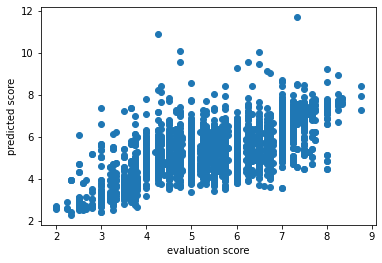

Epoch: 21/50, Train loss: 0.132140, Test loss: 1.013801, Accuracy: 45.34, difference: 0.750670
epoch 22 0.12190476190476189% train finish
epoch 22 12.312380952380952% train finish
epoch 22 24.502857142857142% train finish
epoch 22 36.693333333333335% train finish
epoch 22 48.883809523809525% train finish
epoch 22 61.074285714285715% train finish
epoch 22 73.26476190476191% train finish
epoch 22 85.4552380952381% train finish
epoch 22 97.64571428571429% train finish
epoch 22 train finish
epoch 22 0.4875076173065204% test finish
epoch 22 24.862888482632542% test finish
epoch 22 49.238269347958564% test finish
epoch 22 73.61365021328459% test finish
epoch 22 97.9890310786106% test finish


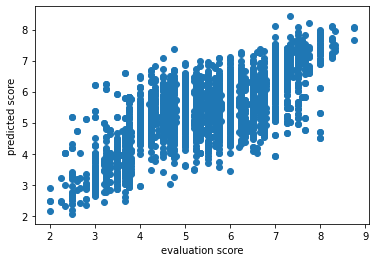

Epoch: 22/50, Train loss: 0.027700, Test loss: 0.781732, Accuracy: 46.86, difference: 0.683594
epoch 23 0.12190476190476189% train finish
epoch 23 12.312380952380952% train finish
epoch 23 24.502857142857142% train finish
epoch 23 36.693333333333335% train finish
epoch 23 48.883809523809525% train finish
epoch 23 61.074285714285715% train finish
epoch 23 73.26476190476191% train finish
epoch 23 85.4552380952381% train finish
epoch 23 97.64571428571429% train finish
epoch 23 train finish
epoch 23 0.4875076173065204% test finish
epoch 23 24.862888482632542% test finish
epoch 23 49.238269347958564% test finish
epoch 23 73.61365021328459% test finish
epoch 23 97.9890310786106% test finish


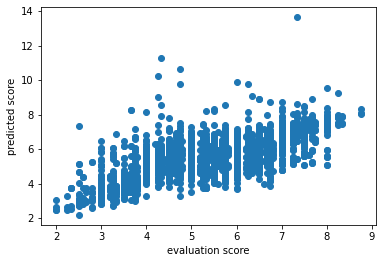

Epoch: 23/50, Train loss: 0.110324, Test loss: 0.914848, Accuracy: 48.32, difference: 0.699040
epoch 24 0.12190476190476189% train finish
epoch 24 12.312380952380952% train finish
epoch 24 24.502857142857142% train finish
epoch 24 36.693333333333335% train finish
epoch 24 48.883809523809525% train finish
epoch 24 61.074285714285715% train finish
epoch 24 73.26476190476191% train finish
epoch 24 85.4552380952381% train finish
epoch 24 97.64571428571429% train finish
epoch 24 train finish
epoch 24 0.4875076173065204% test finish
epoch 24 24.862888482632542% test finish
epoch 24 49.238269347958564% test finish
epoch 24 73.61365021328459% test finish
epoch 24 97.9890310786106% test finish


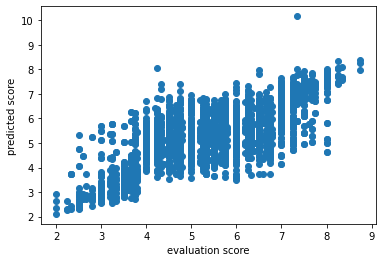

Epoch: 24/50, Train loss: 1.007059, Test loss: 0.778320, Accuracy: 51.40, difference: 0.660088
epoch 25 0.12190476190476189% train finish
epoch 25 12.312380952380952% train finish
epoch 25 24.502857142857142% train finish
epoch 25 36.693333333333335% train finish
epoch 25 48.883809523809525% train finish
epoch 25 61.074285714285715% train finish
epoch 25 73.26476190476191% train finish
epoch 25 85.4552380952381% train finish
epoch 25 97.64571428571429% train finish
epoch 25 train finish
epoch 25 0.4875076173065204% test finish
epoch 25 24.862888482632542% test finish
epoch 25 49.238269347958564% test finish
epoch 25 73.61365021328459% test finish
epoch 25 97.9890310786106% test finish


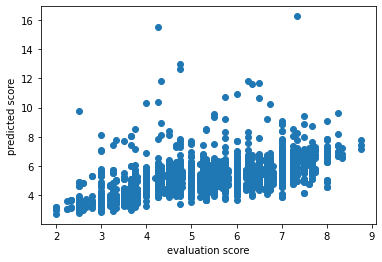

Epoch: 25/50, Train loss: 0.126397, Test loss: 1.250862, Accuracy: 35.89, difference: 0.835395
epoch 26 0.12190476190476189% train finish
epoch 26 12.312380952380952% train finish
epoch 26 24.502857142857142% train finish
epoch 26 36.693333333333335% train finish
epoch 26 48.883809523809525% train finish
epoch 26 61.074285714285715% train finish
epoch 26 73.26476190476191% train finish
epoch 26 85.4552380952381% train finish
epoch 26 97.64571428571429% train finish
epoch 26 train finish
epoch 26 0.4875076173065204% test finish
epoch 26 24.862888482632542% test finish
epoch 26 49.238269347958564% test finish
epoch 26 73.61365021328459% test finish
epoch 26 97.9890310786106% test finish


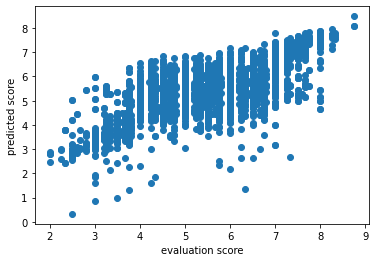

Epoch: 26/50, Train loss: 0.127467, Test loss: 0.805637, Accuracy: 50.30, difference: 0.672405
epoch 27 0.12190476190476189% train finish
epoch 27 12.312380952380952% train finish
epoch 27 24.502857142857142% train finish
epoch 27 36.693333333333335% train finish
epoch 27 48.883809523809525% train finish
epoch 27 61.074285714285715% train finish
epoch 27 73.26476190476191% train finish
epoch 27 85.4552380952381% train finish
epoch 27 97.64571428571429% train finish
epoch 27 train finish
epoch 27 0.4875076173065204% test finish
epoch 27 24.862888482632542% test finish
epoch 27 49.238269347958564% test finish
epoch 27 73.61365021328459% test finish
epoch 27 97.9890310786106% test finish


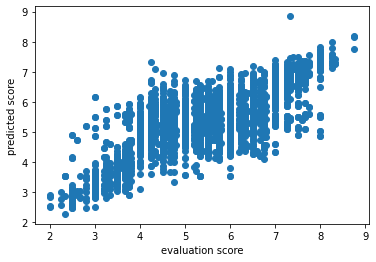

Epoch: 27/50, Train loss: 0.060920, Test loss: 0.737303, Accuracy: 46.83, difference: 0.667846
epoch 28 0.12190476190476189% train finish
epoch 28 12.312380952380952% train finish
epoch 28 24.502857142857142% train finish
epoch 28 36.693333333333335% train finish
epoch 28 48.883809523809525% train finish
epoch 28 61.074285714285715% train finish
epoch 28 73.26476190476191% train finish
epoch 28 85.4552380952381% train finish
epoch 28 97.64571428571429% train finish
epoch 28 train finish
epoch 28 0.4875076173065204% test finish
epoch 28 24.862888482632542% test finish
epoch 28 49.238269347958564% test finish
epoch 28 73.61365021328459% test finish
epoch 28 97.9890310786106% test finish


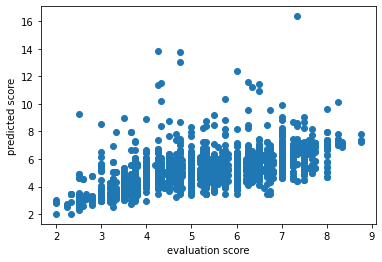

Epoch: 28/50, Train loss: 0.066325, Test loss: 1.188712, Accuracy: 39.79, difference: 0.796114
epoch 29 0.12190476190476189% train finish
epoch 29 12.312380952380952% train finish
epoch 29 24.502857142857142% train finish
epoch 29 36.693333333333335% train finish
epoch 29 48.883809523809525% train finish
epoch 29 61.074285714285715% train finish
epoch 29 73.26476190476191% train finish
epoch 29 85.4552380952381% train finish
epoch 29 97.64571428571429% train finish
epoch 29 train finish
epoch 29 0.4875076173065204% test finish
epoch 29 24.862888482632542% test finish
epoch 29 49.238269347958564% test finish
epoch 29 73.61365021328459% test finish
epoch 29 97.9890310786106% test finish


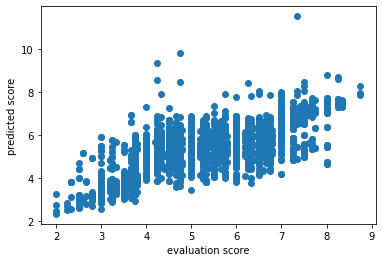

Epoch: 29/50, Train loss: 0.270451, Test loss: 0.797846, Accuracy: 47.99, difference: 0.681257
epoch 30 0.12190476190476189% train finish
epoch 30 12.312380952380952% train finish
epoch 30 24.502857142857142% train finish
epoch 30 36.693333333333335% train finish
epoch 30 48.883809523809525% train finish
epoch 30 61.074285714285715% train finish
epoch 30 73.26476190476191% train finish
epoch 30 85.4552380952381% train finish
epoch 30 97.64571428571429% train finish
epoch 30 train finish
epoch 30 0.4875076173065204% test finish
epoch 30 24.862888482632542% test finish
epoch 30 49.238269347958564% test finish
epoch 30 73.61365021328459% test finish
epoch 30 97.9890310786106% test finish


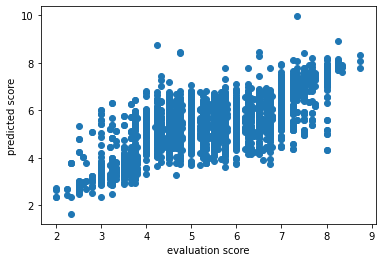

Epoch: 30/50, Train loss: 0.030221, Test loss: 0.793993, Accuracy: 51.01, difference: 0.663811
epoch 31 0.12190476190476189% train finish
epoch 31 12.312380952380952% train finish
epoch 31 24.502857142857142% train finish
epoch 31 36.693333333333335% train finish
epoch 31 48.883809523809525% train finish
epoch 31 61.074285714285715% train finish
epoch 31 73.26476190476191% train finish
epoch 31 85.4552380952381% train finish
epoch 31 97.64571428571429% train finish
epoch 31 train finish
epoch 31 0.4875076173065204% test finish
epoch 31 24.862888482632542% test finish
epoch 31 49.238269347958564% test finish
epoch 31 73.61365021328459% test finish
epoch 31 97.9890310786106% test finish


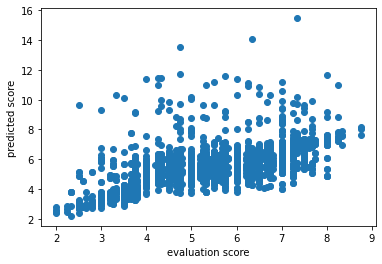

Epoch: 31/50, Train loss: 0.072222, Test loss: 1.222359, Accuracy: 48.32, difference: 0.747296
epoch 32 0.12190476190476189% train finish
epoch 32 12.312380952380952% train finish
epoch 32 24.502857142857142% train finish
epoch 32 36.693333333333335% train finish
epoch 32 48.883809523809525% train finish
epoch 32 61.074285714285715% train finish
epoch 32 73.26476190476191% train finish
epoch 32 85.4552380952381% train finish
epoch 32 97.64571428571429% train finish
epoch 32 train finish
epoch 32 0.4875076173065204% test finish
epoch 32 24.862888482632542% test finish
epoch 32 49.238269347958564% test finish
epoch 32 73.61365021328459% test finish
epoch 32 97.9890310786106% test finish


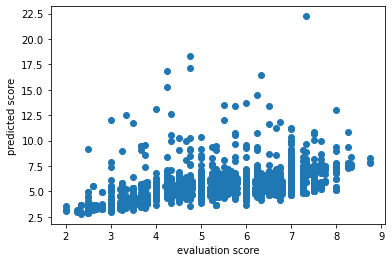

Epoch: 32/50, Train loss: 0.171110, Test loss: 1.584672, Accuracy: 43.30, difference: 0.800744
epoch 33 0.12190476190476189% train finish
epoch 33 12.312380952380952% train finish
epoch 33 24.502857142857142% train finish
epoch 33 36.693333333333335% train finish
epoch 33 48.883809523809525% train finish
epoch 33 61.074285714285715% train finish
epoch 33 73.26476190476191% train finish
epoch 33 85.4552380952381% train finish
epoch 33 97.64571428571429% train finish
epoch 33 train finish
epoch 33 0.4875076173065204% test finish
epoch 33 24.862888482632542% test finish
epoch 33 49.238269347958564% test finish
epoch 33 73.61365021328459% test finish
epoch 33 97.9890310786106% test finish


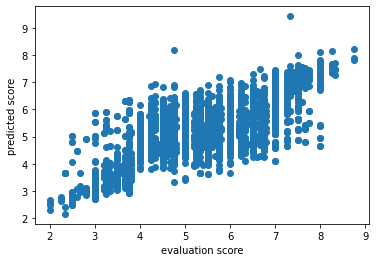

Epoch: 33/50, Train loss: 0.041663, Test loss: 0.775418, Accuracy: 47.93, difference: 0.675691
epoch 34 0.12190476190476189% train finish
epoch 34 12.312380952380952% train finish
epoch 34 24.502857142857142% train finish
epoch 34 36.693333333333335% train finish
epoch 34 48.883809523809525% train finish
epoch 34 61.074285714285715% train finish
epoch 34 73.26476190476191% train finish
epoch 34 85.4552380952381% train finish
epoch 34 97.64571428571429% train finish
epoch 34 train finish
epoch 34 0.4875076173065204% test finish
epoch 34 24.862888482632542% test finish
epoch 34 49.238269347958564% test finish
epoch 34 73.61365021328459% test finish
epoch 34 97.9890310786106% test finish


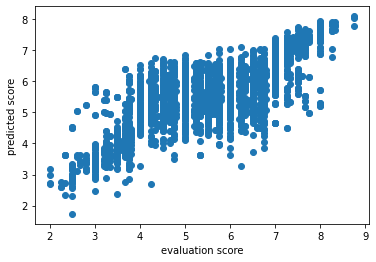

Epoch: 34/50, Train loss: 0.073295, Test loss: 0.719083, Accuracy: 51.25, difference: 0.642322
epoch 35 0.12190476190476189% train finish
epoch 35 12.312380952380952% train finish
epoch 35 24.502857142857142% train finish
epoch 35 36.693333333333335% train finish
epoch 35 48.883809523809525% train finish
epoch 35 61.074285714285715% train finish
epoch 35 73.26476190476191% train finish
epoch 35 85.4552380952381% train finish


KeyboardInterrupt: 

: 

In [17]:
import gc
gc.collect()              
torch.cuda.empty_cache()
train(model, params)

In [ ]:

from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
+=1

SyntaxError: invalid syntax (1170883156.py, line 1)

: 

## 테스트

In [ ]:
#@title
import cv2
class TestDataSet(Dataset):
    def __init__(self, overall_image_path, transform=None):
        print("initialize data sets")
        self.transform = transform
        rating_dict = {}
        self.image_list = list()
        self.score_list = list()
        cnt = 0
        year_image_path = overall_image_path
        # year_image_path = overall_image_path+"iclr"+year+"/"
        with jsonlines.open(f"drive/Shareddrives/소종-논문/iclr2021_metadata.jsonl") as read_file:
            for line in read_file.iter():
                rating_dict[line['forum']] = line['rating']
        input_paths = os.listdir(year_image_path)
        input_paths.sort()
        for one_file_image_path in tqdm(input_paths, desc="make data set"):
            image_path = year_image_path + one_file_image_path + "/"
            before_add_size = len(self.image_list)
            imgs = glob.glob(image_path + "1.bin")
            imgs.sort()
            self.image_list.extend(imgs) # glob: 폴더 내의 파일 찾아줌
            rating = rating_dict[one_file_image_path]
            self.score_list.extend([rating] * (len(self.image_list)-before_add_size))
            cnt += len(self.image_list)-before_add_size

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        label = self.score_list[idx]
        binary_file = image_path   # binary_file = dataset/image/iclr2021/_0kaDkv3dVf/3.bin 
        with open(binary_file, 'rb') as f:
            data = f.read()
        encoded_img = np.fromstring(data, dtype=np.uint8)
        img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def img_list(self):
      print(self.image_list)

In [ ]:
image_path = "drive/Shareddrives/소종-논문/test/binary/occlusion/" 
dataset_file_name = 'iclr2021_dataset_test.pt'

In [ ]:
def test_make_save_data_set(image_path, dataset_file_name):
  print("start to make data set")
  transform = transforms.Compose([
      transforms.ToTensor(),
  ])

  dataset = TestDataSet(image_path, transform=transform)
  print(f"data set length: {dataset.__len__()}")

  torch.save(dataset, dataset_file_name)
  print("save data sets")

In [ ]:
test_make_save_data_set(image_path, dataset_file_name)

start to make data set
initialize data sets


FileNotFoundError: [Errno 2] No such file or directory: 'drive/Shareddrives/소종-논문/iclr2021_metadata.jsonl'

In [ ]:
from torch.utils.data.dataset import random_split
import torchvision.datasets as dset

dataset = torch.load(dataset_file_name)

test_size = len(dataset)
print("test size:", test_size)
# validation 

dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=False)

test size: 45


In [ ]:
import time
import datetime
from numpy import vstack

def test(model, params):
    total_start = time.time()
    loss_function=params["loss_function"]
    test_dataloader=dataloader
    device=params["device"]

    print("start train")
    print("test size:", test_size)

    # test accuracy 계산
    total = 0
    correct = 0
    loss = 0
    model.eval()
    
    for i, data in enumerate(test_dataloader, 0):
      print("i:", i)
      
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)

      print("size:",labels.size(0))
      print("label:", labels)
      

      # 결과값 연산
      outputs = model(inputs).squeeze()
      print("output:", outputs)
      i_batch_size = labels.size(0)
      total += i_batch_size
      correct += (abs(outputs - labels)<0.5).sum().item() # 변경될 수 있음 
      test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
      loss += i_batch_size * test_loss

      # 학습 결과 출력
    print('Test loss: %.6f, Accuracy: %.2f' %(loss/total, 100*correct/total))

    total_elapsed_time = time.time() - total_start
    total_elapsed_time_list = str(datetime.timedelta(seconds=total_elapsed_time)).split(".")
    print(f"Total Elapsed time is {total_elapsed_time_list[0]}")  

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
test(model, params)

start train
test size: 45
i: 0
size: 32
label: tensor([8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500,
        5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        4.0000, 4.0000, 4.0000, 4.0000, 4.0000], device='cuda:0')
output: tensor([6.5816, 6.5845, 6.5476, 6.7172, 6.5774, 6.7502, 6.5787, 6.6212, 6.6677,
        5.2512, 4.5495, 5.4114, 5.3056, 5.1830, 4.2590, 5.1306, 4.4159, 5.0974,
        4.9216, 4.9011, 4.5559, 5.0236, 4.7439, 5.2108, 4.7982, 5.3017, 4.9362,
        4.7339, 4.6832, 5.0069, 4.9728, 4.8730], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


i: 1
size: 13
label: tensor([4., 4., 4., 4., 7., 7., 7., 7., 7., 7., 7., 7., 7.], device='cuda:0')
output: tensor([5.2232, 4.7544, 4.4490, 4.9124, 6.6159, 6.6060, 6.7244, 6.4929, 6.6800,
        6.5359, 6.5436, 6.2699, 6.6201], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Test loss: 2.917464, Accuracy: 31.11
Total Elapsed time is 0:00:00


## 안쓰는 코드

In [ ]:
lst = list()
with jsonlines.open("iclr2021_metadata.jsonl") as read_file:
  for line in read_file.iter():
    lst.append(float(line['rating']))
avg = sum(lst)/len(lst)
print(avg)

In [ ]:
avg_lst = [avg] * len(lst)
loss_function = nn.MSELoss()
test_loss = loss_function(torch.Tensor(lst).to(torch.float32), torch.Tensor(avg_lst).to(torch.float32)).item()
print(test_loss)

In [ ]:
total = 0
loss = 0
for i, data in enumerate(test_dataloader, 0):
  inputs, labels = data
  inputs = inputs.to(device)
  labels = labels.type(torch.FloatTensor) 
  labels = labels.to(device)
  
  i_batch_size = labels.size(0)
  outputs = [avg] * i_batch_size
  outputs = torch.Tensor(outputs).to(device)
  total += i_batch_size
  test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
  loss += i_batch_size * test_loss

print('loss: %.6f' %(loss/total))

In [ ]:
 from torchvision import models
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정

resnet50 = models.resnet50(pretrained=True) # true 옵션으로 사전 학습된 모델을 로드

for param in resnet50.parameters():
    param.requires_grad = False

model2 = nn.Sequential(
    resnet50,
    nn.Flatten(),
    nn.Linear(1000, 256),
    nn.ReLU(),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
).to(device)
